In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data (if not already loaded)
df = pd.read_csv("Task 3 and 4_Loan_Data.csv")

# Keep only what we need for Task 4
fico_df = df[["fico_score", "default"]].copy()

fico_df.describe()


,fico_score,default
count,10000.000000,10000.000000
mean,637.557700,0.185100
std,60.657906,0.388398
min,408.000000,0.000000
25%,597.000000,0.000000
50%,638.000000,0.000000
75%,679.000000,0.000000
max,850.000000,1.000000


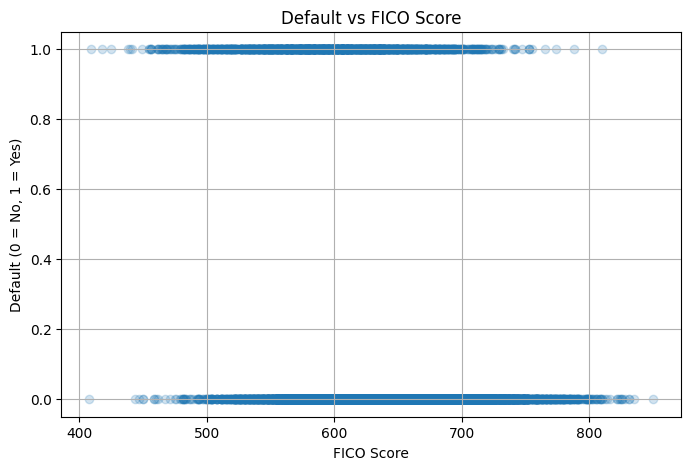

In [3]:
plt.figure(figsize=(8,5))
plt.scatter(fico_df["fico_score"], fico_df["default"], alpha=0.2)
plt.xlabel("FICO Score")
plt.ylabel("Default (0 = No, 1 = Yes)")
plt.title("Default vs FICO Score")
plt.grid(True)
plt.show()


In [4]:
fico_df["fico_band"] = pd.cut(fico_df["fico_score"], bins=10)

band_summary = fico_df.groupby("fico_band")["default"].mean()

band_summary


/tmp/ipython-input-983927428.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  band_summary = fico_df.groupby("fico_band")["default"].mean()


,default
fico_band,
"(407.558, 452.2]",0.583333
"(452.2, 496.4]",0.735043
"(496.4, 540.6]",0.510251
"(540.6, 584.8]",0.353741
"(584.8, 629.0]",0.204824
"(629.0, 673.2]",0.132526
"(673.2, 717.4]",0.078664
"(717.4, 761.6]",0.035519
"(761.6, 805.8]",0.018634


In [5]:
# Number of buckets (ratings)
N_BUCKETS = 5

# Create quantile-based buckets
fico_df["bucket"] = pd.qcut(fico_df["fico_score"], q=N_BUCKETS, duplicates="drop")

# See bucket ranges and counts
bucket_table = fico_df.groupby("bucket").agg(
    count=("default", "count"),
    defaults=("default", "sum"),
    pd=("default", "mean"),
    min_fico=("fico_score", "min"),
    max_fico=("fico_score", "max")
)

bucket_table


/tmp/ipython-input-116373854.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bucket_table = fico_df.groupby("bucket").agg(


,count,defaults,pd,min_fico,max_fico
bucket,,,,,
"(407.999, 587.0]",2050,817,0.398537,408,587
"(587.0, 623.0]",1971,425,0.215627,588,623
"(623.0, 653.0]",1989,301,0.151332,624,653
"(653.0, 688.0]",1997,200,0.100150,654,688
"(688.0, 850.0]",1993,108,0.054190,689,850


In [6]:
bucket_table = bucket_table.sort_values("min_fico", ascending=False)
bucket_table["rating"] = range(1, len(bucket_table) + 1)

bucket_table


,count,defaults,pd,min_fico,max_fico,rating
bucket,,,,,,
"(688.0, 850.0]",1993,108,0.054190,689,850,1
"(653.0, 688.0]",1997,200,0.100150,654,688,2
"(623.0, 653.0]",1989,301,0.151332,624,653,3
"(587.0, 623.0]",1971,425,0.215627,588,623,4
"(407.999, 587.0]",2050,817,0.398537,408,587,5


In [7]:
# Reset index to access bucket ranges
rating_map = bucket_table.reset_index()

rating_map


,bucket,count,defaults,pd,min_fico,max_fico,rating
0,"(688.0, 850.0]",1993,108,0.054190,689,850,1
1,"(653.0, 688.0]",1997,200,0.100150,654,688,2
2,"(623.0, 653.0]",1989,301,0.151332,624,653,3
3,"(587.0, 623.0]",1971,425,0.215627,588,623,4
4,"(407.999, 587.0]",2050,817,0.398537,408,587,5


In [8]:
def fico_to_rating_and_pd(fico_score, rating_map):
    for _, row in rating_map.iterrows():
        low = row["bucket"].left
        high = row["bucket"].right
        if low <= fico_score <= high:
            return int(row["rating"]), float(row["pd"])
    return None, None


In [9]:
from sklearn.tree import DecisionTreeClassifier

# Feature and target
X_fico = fico_df[["fico_score"]]
y = fico_df["default"]

# Train shallow decision tree (controls number of buckets)
tree_model = DecisionTreeClassifier(
    max_leaf_nodes=5,    # number of buckets you want
    min_samples_leaf=300,
    random_state=42
)

tree_model.fit(X_fico, y)

print("Tree trained")


Tree trained


In [10]:
# Extract split thresholds
thresholds = tree_model.tree_.threshold
thresholds = thresholds[thresholds != -2]
thresholds = sorted(thresholds)

thresholds


[np.float64(520.5), np.float64(552.5), np.float64(580.5), np.float64(640.5)]

In [11]:
# Create bucket edges
bins = [-float("inf")] + thresholds + [float("inf")]

fico_df["opt_bucket"] = pd.cut(fico_df["fico_score"], bins=bins)

opt_bucket_table = fico_df.groupby("opt_bucket").agg(
    count=("default", "count"),
    defaults=("default", "sum"),
    pd=("default", "mean"),
    min_fico=("fico_score", "min"),
    max_fico=("fico_score", "max")
).reset_index()

# Best credit = highest FICO = rating 1
opt_bucket_table = opt_bucket_table.sort_values("min_fico", ascending=False)
opt_bucket_table["rating"] = range(1, len(opt_bucket_table)+1)

opt_bucket_table


/tmp/ipython-input-4024001537.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  opt_bucket_table = fico_df.groupby("opt_bucket").agg(


,opt_bucket,count,defaults,pd,min_fico,max_fico,rating
4,"(640.5, inf]",4854,413,0.085084,641,850,1
3,"(580.5, 640.5]",3438,703,0.204479,581,640,2
2,"(552.5, 580.5]",911,307,0.336992,553,580,3
1,"(520.5, 552.5]",496,229,0.461694,521,552,4
0,"(-inf, 520.5]",301,199,0.661130,408,520,5


In [12]:
def fico_to_rating_pd_optimal(fico_score, table):
    for _, row in table.iterrows():
        if row["min_fico"] <= fico_score <= row["max_fico"]:
            return int(row["rating"]), float(row["pd"])
    return None, None


In [13]:
for score in [560, 610, 650, 700, 760]:
    r, p = fico_to_rating_pd_optimal(score, opt_bucket_table)
    print(f"FICO {score} → Rating {r}, PD {round(p,4)}")


FICO 560 → Rating 3, PD 0.337
FICO 610 → Rating 2, PD 0.2045
FICO 650 → Rating 1, PD 0.0851
FICO 700 → Rating 1, PD 0.0851
FICO 760 → Rating 1, PD 0.0851
